# Scenario B - Baseline Variation

In this scenario the baseline underlying a spectrum with a fixed number of peaks (3) is varied between no baseline, a constant offset and a linear baseline. The noise level is kept constant at 1%.

The models used in the inference of the parameters are formulated as follows:

1. No baseline:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

2. Constant offset:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + a_0 + \epsilon
\end{equation}

3. Linear baseline:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + a_0 + a_1 \cdot x + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_baseline'
file_basename = out_path + '/scenario_baseline'
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf = {}
    
# scenario name
conf['scenario'] = 'baseline variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# dataset directory (needed for 'preload' data mode)
#conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
conf

{'scenario': 'baseline variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'generate',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lbline = []

# number of spectra per baseline variation
nsets  = 4

# baseline variation
baselines = ["none", "offset", "linear"]
lbline = [bl for bl in baselines for i in range(nsets)]

# total number of datasets
tsets = nsets * len(baselines)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for blv in baselines:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, npeaks=3, tbaseline=blv)
            ldata.append(df)
            lpeaks.append(peaks)
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, _ = dg.data_load(tsets, out_path)

In [7]:
print("total number of baseline variations     : {0}".format(len(baselines)))
print("total number of spectra per baseline    : {0}".format(nsets))
print("total number of datasets per model      : {0}".format(tsets))
print("total number of inference runs          : {0}".format(nsets*len(baselines)**2))

total number of baseline variations     : 3
total number of spectra per baseline    : 4
total number of datasets per model      : 12
total number of inference runs          : 36


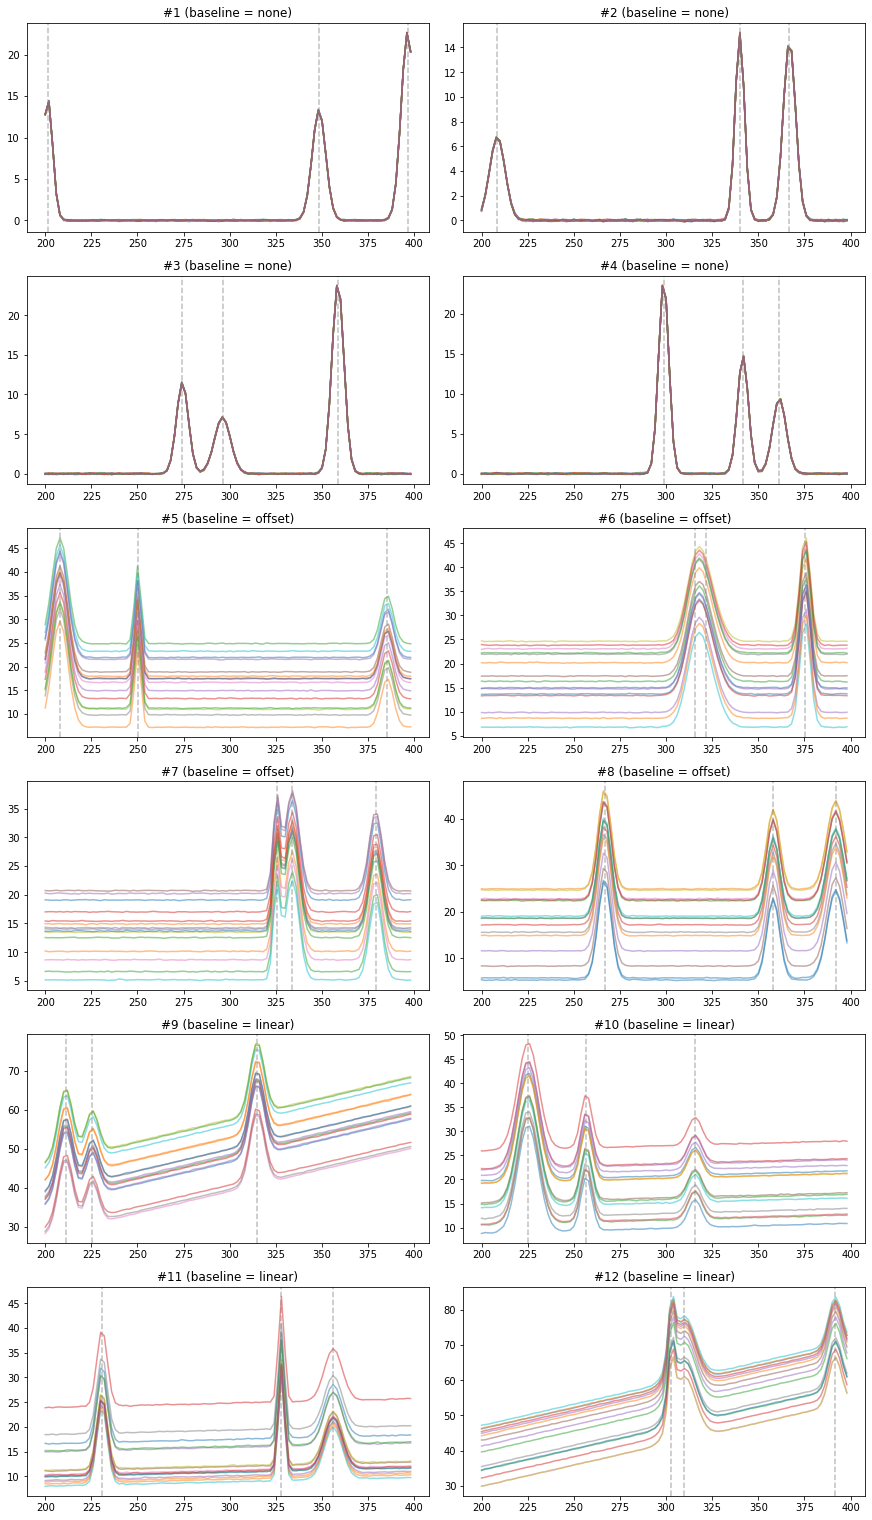

In [8]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                                        savefig='yes', fname=file_basename, title='baseline', baselines=lbline)

# Initialize models and run inference

In [9]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [ ]:
# initialize models and run inference
models = []
traces = []

# list of tuples with (model,peak) combination
lmodpeak = []

# actual run number
run = 1

# total number of inference runs
truns = nsets * len(peak_numbers)**2

for bl in baselines:
    if conf['model_mode'] == 'train':
        # for each model+baseline run inference on all spectra
        print("running {0} model".format(bl))
    
    for i in range(len(ldata)):
        if conf['peak_info'] == 'yes':
            # Get the peak numbers from the list. If the actual peak number in the spectrum is 
            # lower than what the model is expecting, then expand the list to the expected size,
            # duplicating the existing peak mu values, else truncate the list (taking the peaks
            # with the highest amplitude).
            plist = sorted(lpeaks[i])
            if len(plist) < pn:
                pl = sorted(np.resize(plist, (1,pn)).flatten())
            else:
                # sort peak info dataframe on amplitude value 
                l1 = lpeakdata[i].sort_values('amp', ascending=False)
                # truncate list to expected peak number
                pl = l1['mu'].values[:pn]
                
            model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=pn, 
                                      mu_peaks=pl, pmodel=conf['prior_model'])
        else:
            model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=pn,
                                      pmodel=conf['prior_model'])      
        models.append(model_g)

        with model_g:
            if conf['model_mode'] == 'train':
                print("({2}/{3}) running inference on dataset #{0}/{1} [{4}-peak model:{5}-peak spectrum]"
                      .format(i+1,len(ldata),run,truns,pn,len(plist)))
                lmodpeak += [(pn,len(plist))]
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (run), trace_g)
            else:
                # load traces from disk
                print("loading dataset #{0}/{1}".format(run,truns))
                trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (run))
                traces.append(trace_g)
            run += 1

# Model visualization

In [ ]:
pm.model_to_graphviz(models[0])

In [ ]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [ ]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

In [ ]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [ ]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val, epsilon_real=0.05, sets=tsets, labels=lmodpeak)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
#df.sort_values(by=['r2'])
df

In [ ]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
                    savefig='yes', fname=file_basename, showpeaks='no', sets=tsets, labels=lmodpeak)

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
                    savefig='yes', fname=file_basename, showpeaks='yes', sets=tsets, labels=lmodpeak)

In [ ]:
cnf.close(out_path)